In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from keras.models import model_from_json
import numpy as np
import json
import requests
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_all = pd.read_csv('data/19999_question_category_b_is_v4.csv')
print(f"df_all shape : {df_all.shape}")

df_all shape : (1336, 8)


In [3]:
mapping = df_all.category.astype('category').cat.categories
mapping

Index(['BPM平台系統', 'R&D資訊系統', '內部資訊系統'], dtype='object')

In [4]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/Project_19999/19999_CNN/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u1430022de19ce5d7760cc83d31504a1a.cache
Loading model cost 0.516 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,無法
2,安裝


In [6]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [7]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,下面issue 無法open…完成後會跳到另外一個issue 但原本issue 未Ope...,R&D資訊系統,測試相關服務,【QITS】研發議題追蹤系統,相關操作詢問,R&D資訊系統,下麵 無法open…完成後會跳到一個 但原本 未open完成 再幫忙看一下 ...,1
1,"1. Issue Status秀出來的文字裡面,出現斷行符號,但實際上看不到斷行效果 2....",R&D資訊系統,測試相關服務,【QITS】研發議題追蹤系統,相關操作詢問,R&D資訊系統,1. status秀出來的文字裡面出現斷行符號但實際上看不到斷行效果 2. assig...,1
2,"QCMC那邊的測試人員反應無法使用QITS系統,原本NB7的使用權限被刪除,如附件一 另外...",R&D資訊系統,測試相關服務,【QITS】研發議題追蹤系統,相關操作詢問,R&D資訊系統,的測試人員反應qits系統原本nb7的使用權限被刪除如附件一 原本已被刪除的權限現在又跑出...,1
3,Chris Wu (吳振瑋) 新增 BU3 bios 人員,R&D資訊系統,測試相關服務,【QITS】研發議題追蹤系統,相關操作詢問,R&D資訊系統,新增 bu3 bios 人員,1
4,Please help create new platform-Chipset “AMD R...,R&D資訊系統,測試相關服務,【QITS】研發議題追蹤系統,相關操作詢問,R&D資訊系統,please help create new platformcpset “amd rich...,1


In [8]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list

In [9]:
def cut_to_word(s):
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        combie = combie + w
        if i < len(w_list) - 1:
            combie = combie + ','
            
    return combie    

# print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word(s.strip()))

In [10]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,"在進入 公司教育訓練課程時,例如 職業安全衛生在職教育訓練-作業場所安全與衛生管理篇 時 ...",內部資訊系統,人資資訊系統,MyeHR相關服務,系統操作,內部資訊系統,在進入 公司教育訓練課程時 職業安全衛生在職教育訓練作業場所安全與衛生管理篇 時 沒有播...,2,"進入,公司,教育,訓練,課程,時,職業,安全衛生,在職,教育,訓練,作業,場所,安全,衛生,..."
1,分機15777 需要在申請單內新增簽核人員,BPM平台系統,管理類相關服務,核示申請單,相關操作詢問,BPM平台系統,需要在申請單內新增簽核人員,0,"需要,申請單,新增,簽核,人員"
2,無法登入MyBPM簽核表單。#36811,BPM平台系統,管理類相關服務,放行申請單,系統無法登入,BPM平台系統,mybpm簽核表單,0,"mybpm,簽核,表單"
3,申報加班主管收不到通知 MIS您好，昨天早上我送出加班申請，到了下午收到助理的mail...,內部資訊系統,人資資訊系統,出勤相關服務,加班問題,內部資訊系統,申報加班收不到通知 mis早上我送出加班申請到了下午收到的mail說未簽核早上和後發現...,2,"申報,加班,收不到,通知,mis,早上,送,加班,申請到,下午,收到,mail,說,未,簽核..."
4,為客戶申請無線網路申請單，單不能 由訪客申請單導入,BPM平台系統,資訊類相關服務,資訊需求申請單,相關操作詢問,BPM平台系統,為客戶申請無線網路申請不能 由訪客申請單導入,0,"客戶,申請,無線網路,申請,訪客,申請單,導入"


In [11]:
# df_all[3040:4010]

In [12]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 40)

In [14]:
X_train.head()

426    qits,欲,新增,report,report,篩選,條件,中,設定,project,nam...
318                              放輕鬆,學,英文,教學,影片,無法,播放,常熟
336                                         列印,資料會,產生,錯誤
682                                  06,26,下班時間,無法,申報,加班
202                                      bpm,點選,po,結案,畫面
Name: cut_words, dtype: object

In [15]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 1. 0.]
[0. 1. 0.]
num_classes = 3


In [16]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)

    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)

In [17]:
x_train

array([[   0,    0,    0, ..., 1466,   14, 1467],
       [   0,    0,    0, ...,    1,  107, 1471],
       [   0,    0,    0, ..., 1472,  129,    6],
       ...,
       [   0,    0,    0, ...,  135,    3,  714],
       [   0,    0,    0, ...,    1, 2756,   87],
       [   0,    0,    0, ...,  159,   21,    6]], dtype=int32)

In [18]:
"""
訓練model
"""
# set parameters:

batch_size = 20
filters = 32
kernel_size = 7
epochs = 50
train_ratio = 0.9


In [19]:
# model.add(Conv1D(activation="relu", padding="same", filters=64, kernel_size=5))
# model.add(MaxPooling1D(pool_size=4))

In [20]:
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len):
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=32, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.75))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
                     
    # We add a vanilla hidden layer:
#     model.add(Dense(128))
#     model.add(Dropout(0.5))
#     model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [21]:
model = build_1DCNN_model(num_classes, NUM_WORDS, MAX_LEN)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            160032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0     

In [22]:
model_path = '{}.h5'.format('19999_1dcnn_is')

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

model_history = model.fit(x_train, y_train_one_hot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split= 1 - train_ratio,
          callbacks = [checkpoint, earlystop])

Train on 841 samples, validate on 94 samples
Epoch 1/50
841/841 [==============================] - 2s 2ms/step - loss: 1.0750 - acc: 0.4590 - val_loss: 1.0704 - val_acc: 0.4574

Epoch 00001: val_loss improved from inf to 1.07035, saving model to 19999_1dcnn_is.h5
Epoch 2/50
841/841 [==============================] - 0s 153us/step - loss: 1.0505 - acc: 0.4816 - val_loss: 1.0647 - val_acc: 0.4574

Epoch 00002: val_loss improved from 1.07035 to 1.06470, saving model to 19999_1dcnn_is.h5
Epoch 3/50
841/841 [==============================] - 0s 144us/step - loss: 1.0498 - acc: 0.4839 - val_loss: 1.0586 - val_acc: 0.4574

Epoch 00003: val_loss improved from 1.06470 to 1.05858, saving model to 19999_1dcnn_is.h5
Epoch 4/50
841/841 [==============================] - 0s 143us/step - loss: 1.0410 - acc: 0.4946 - val_loss: 1.0421 - val_acc: 0.4787

Epoch 00004: val_loss improved from 1.05858 to 1.04206, saving model to 19999_1dcnn_is.h5
Epoch 5/50
841/841 [==============================] - 0s 143u

In [23]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


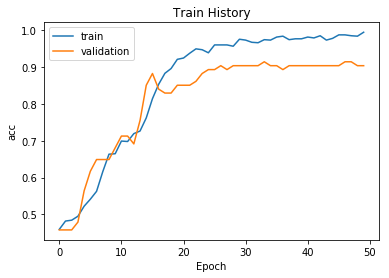

In [24]:
show_train_history(model_history,'acc','val_acc')

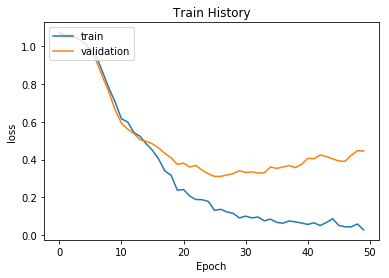

In [25]:
show_train_history(model_history,'loss','val_loss')

In [26]:
mapping

Index(['BPM平台系統', 'R&D資訊系統', '內部資訊系統'], dtype='object')

In [27]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
    model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict(x_val)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
answer_name = to_cat_name(y_val)

In [29]:
model.predict_classes(x_val)

array([1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1,
       1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 1, 2,
       0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 0,
       2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0,
       2, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 0,
       0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2,
       0, 1, 2, 0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 2, 2, 2, 0,
       0, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2,

In [30]:
x_val

array([[   0,    0,    0, ...,  285,  926,  118],
       [   0,    0,    0, ...,    1,  117,   66],
       [   0,    0,    0, ...,  100,  639,   66],
       ...,
       [   0,    0,    0, ...,    1,   54,   69],
       [   0,    0,    0, ...,    6,    6,   13],
       [   0,    0,    0, ...,   87,   33, 3287]], dtype=int32)

In [31]:
mapping

Index(['BPM平台系統', 'R&D資訊系統', '內部資訊系統'], dtype='object')

In [32]:
# model.predict(x_val)

In [33]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [34]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [35]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.8453865336658354 !!!!!!!!


In [36]:
# predict_df[predict_df['2_y_predict'] == predict_df['4_answer']]

In [37]:
predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
821,"任用,建議表,gwf039,單號,app56,按下,簽核,同意,按鈕,時,遇到,伺服器,錯誤...",0,BPM平台系統,2,內部資訊系統,"[0.97537893, 0.0003950356, 0.024226135]"
85,dasdas,2,內部資訊系統,0,BPM平台系統,"[0.4391201, 0.09709753, 0.46378237]"
1173,"出現,登入,失敗",2,內部資訊系統,1,R&D資訊系統,"[0.18435793, 0.31950766, 0.4961345]"
132,"oracderror,message,only,use,less,than,60,compo...",0,BPM平台系統,1,R&D資訊系統,"[0.8428869, 0.014239033, 0.1428741]"
672,"連結,每月,設備,狀態,無,資料,顯示",1,R&D資訊系統,2,內部資訊系統,"[0.0056738984, 0.9352675, 0.059058644]"
900,"使用,登入,幫忙,簽核,卻,功能,請,協助",2,內部資訊系統,0,BPM平台系統,"[0.19245842, 0.25565192, 0.55188966]"
1250,"申請,請假,發生,錯誤,伺服器,無法,要求,999",0,BPM平台系統,2,內部資訊系統,"[0.9637219, 0.00043453817, 0.035843637]"
1106,"已,離職,plm,申請,項目,無法,完成,取消,重新,申請",0,BPM平台系統,1,R&D資訊系統,"[0.7705598, 0.030975457, 0.19846472]"
816,"系統,目前,中,需要,協助",1,R&D資訊系統,0,BPM平台系統,"[0.08285365, 0.5370095, 0.38013685]"
1101,"人才,招募,網網,頁,bpm,系統,問題,系統,恢復,後,通知",0,BPM平台系統,2,內部資訊系統,"[0.80124545, 0.009199422, 0.18955514]"


In [38]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'], margins=True)

answer,BPM平台系統,R&D資訊系統,內部資訊系統,All
predict,,,,
BPM平台系統,181,9,14,204
R&D資訊系統,7,84,6,97
內部資訊系統,13,13,74,100
All,201,106,94,401


In [39]:
# model_path = '{}.h5'.format('19999_1dcnn')
# model.save(model_path)

In [40]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)